# api notebook

https://ims.gov.il/he/ObservationDataAPI

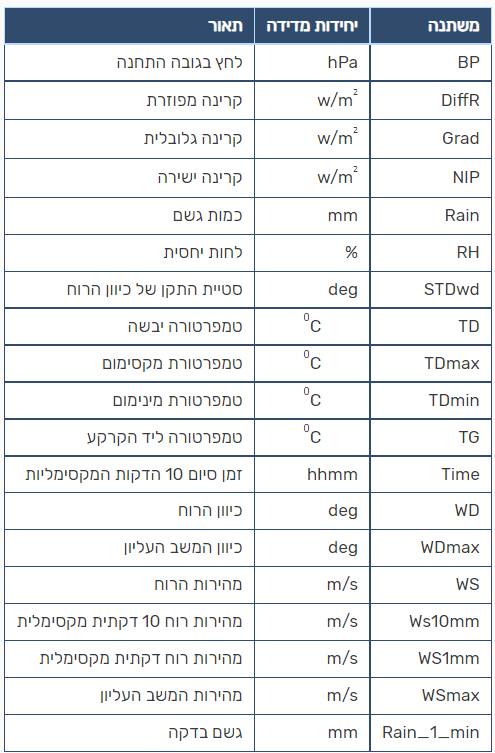

In [24]:
import pandas as pd
import numpy as np

import requests
import json

import selenium
from selenium import webdriver
import time
import os

from random import randint
from time import sleep
import asyncio

### Connection to API ###

#### We declare connection HTTP headers with authorization data we got from the Israel Meteorological Service ####

In [1]:
authorization_headers={ 'Authorization': 'ApiToken f058958a-d8bd-47cc-95d7-7ecf98610e47' }

In [26]:
url_stations_metadata=  "https://api.ims.gov.il/v1/Envista/stations"
stations_metadata = requests.request("GET", url_stations_metadata, headers=authorization_headers) 
stations_metadata_json = json.loads(stations_metadata.text.encode('utf8'))
stations_df=pd.json_normalize(stations_metadata_json)

### Generating DF of stations in areas with chose ###

In [27]:
#unnecessary data
cols_to_remove=['monitors','StationTarget']

for col in cols_to_remove:
    del stations_df[col]
#we chose to focus on central areas and these are the region ids from the Israel Meteorological API 
regions=[6,11,13,14,15]
specific_stations_df= None
for region in regions:
    stations_df_copy=stations_df.copy()
    if specific_stations_df is None:
        specific_stations_df=stations_df_copy[stations_df_copy.regionId == region]
    else:
        specific_stations_df=specific_stations_df.append(stations_df_copy[stations_df_copy.regionId == region])
stations_id_list=np.array(specific_stations_df['stationId'].tolist())
print(stations_id_list)
specific_stations_df.to_csv("specific_stations.csv")

[ 18  26 243  42  43  45  67 263 311 312 314 317 332  54  85 178 212 275
 299 318  58  74  79  82 121 124 208 236 244 245 252 274 283 284 285 291
 336  41  44  46  78 106 107 246 276 310 313 315 343 345]


#### we checked which data returns for each station in the response JSON (using postman) and generating columns for df row accordingly ####

In [28]:
def generate_row_per_dateTime(obj,station):
    row={}
    row['stationId']=station
    date_end_index=obj["datetime"].find('T')
    row['date']=obj["datetime"][:date_end_index]
    for channel in obj['channels']:
        if(channel["valid"]):
            colName=channel["name"]
            colValue=channel["value"]
            row[colName]= colValue
    return json.dumps(row)  

In [29]:
def extract_data_station(month_json,station):
    station_data_df=None
    params=[]
    title=''
    count=0
    colName=''
    colValue=''
    json_row=None
    current_df_row=None
    for obj in month_json['data']:
        count=count+1
        json_row=json.loads(generate_row_per_dateTime(obj,station))
        current_df_row=pd.json_normalize(json_row)
        if station_data_df is None:
            station_data_df=current_df_row
        else:
            station_data_df=station_data_df.append(current_df_row)
        json_row=None
    return station_data_df

### Getting ready to merge ###

#### The next 2 functions responsible to adjust station data df  to the crawling data of traffic in the next notebook (for future merging) ####

In [30]:
def getPartialDataFrameByColumnValue(df,columnName,value):
    return df[df[columnName].str.contains(value)]

In [31]:
def getAverageDataFrameByColumn(df,columnName):
    df_copy=df.copy()
    rows_number=df.shape[0]
    station_identity_df=pd.DataFrame()
    station_metadata_df=pd.DataFrame()
    current_date_df=pd.DataFrame()
    merged_df=None
    date=0
    
    stationId=df_copy['stationId'][0]
    station_identity_df=pd.DataFrame({'stationId':[stationId]})
    station_metadata_df=getPartialDataFrameByColumnValue(df_copy,'date',df_copy['date'].iloc[0])
    station_metadata_df.drop(['stationId'], axis=1, inplace=True)
    station_metadata_df.drop(['date'], axis=1, inplace=True) 
    station_metadata_df=station_metadata_df.mean(axis=0).to_frame().T
    current_date_df=pd.concat([station_identity_df,station_metadata_df],axis=1)

    return current_date_df
    

### Final DF generation ###

#### Now we request for weather data in all stations ####

In [ ]:
years=[2017,2018,2019,2020,2021,2022]
months=['01','02','03','04','05','06','07','08','09','10','11','12']
current_station= None
final_stations_data_after_avg=None
problematic_urls=[]
average_for_month_df=None
for station in stations_id_list:
    for year in years:
        for month in months:
            url='https://api.ims.gov.il/v1/envista/stations/{}/data/monthly/{}/{}'.format(station,year,month)
            print(url)
            try:
                station_metadata = requests.request( "GET",url, headers=authorization_headers,timeout=20)
                sleep(0.03)
                if station_metadata.status_code != 204:
                    station_metadata_json = json.loads(station_metadata.text.encode('utf8','ignore'))
                    current_station=extract_data_station(station_metadata.json(),station)
                    current_station = current_station.reset_index()
                    current_station.drop(['index'], axis=1, inplace=True)
                    average_for_month_df=getAverageDataFrameByColumn(current_station,'date').reset_index()
                    average_for_month_df.drop(['index'], axis=1, inplace=True)
                    average_for_month_df['year']=year
                    average_for_month_df['month']=month
                    if final_stations_data_after_avg is None:
                        final_stations_data_after_avg=average_for_month_df
                    else:
                        final_stations_data_after_avg=final_stations_data_after_avg.append(average_for_month_df)
            except Exception as e:
                print(e)
                problematic_urls.append(url)
            
        
        sleep(0.03)

print('finished')


In [16]:
final_stations_data_after_avg.to_csv('final_stations_data_after_avg.csv')

#### The problematic_urls array is for not missing data if a request fails

In [17]:
print(len(problematic_urls))

0
